In [91]:
import numpy as np
import cv2
from scipy.stats import chi2

import json
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import utils as ut

import spectral as sp

In [11]:
MASK = 'data/mask.png'
IMAGE_FOLDER = 'data/train/train-1-0/'

mask = cv2.imread(MASK,0)
homographies = json.loads(open(IMAGE_FOLDER+'homographies.json','r').read())

#images = []

orig_images = []
warped_images = []

for root, dirs, files in os.walk(IMAGE_FOLDER):
    for file in files:
        if file.endswith('.png'):
            img = cv2.imread(os.path.join(root,file))
            w,h,_ = img.shape
            res = cv2.bitwise_and(img,img,mask=mask) #apply the mask to remove the timestamp
            orig_images.append(res) #save the original

            w,h,_ = img.shape
            name = file.replace('.png','')
            M = np.array(homographies[name]) #get homography

            res = cv2.warpPerspective(res, M, (w,h)) #warp the image using the given homography
            warped_images.append(res)

In [60]:
def display_images(images, figsize=None, resize_dim=(200, 200)):
    if figsize: row, col = figsize
    else: row, col = 1,1
        
    fig, axs = plt.subplots(row, col, figsize=figsize)
    if row>1 or col>1: axs = axs.flatten()
    else: axs = [axs]
    fig.set_figwidth(20)
    fig.set_figheight(15)
    
    for img, ax in zip(images, axs):
        ax.imshow(cv2.resize(img, resize_dim), interpolation='nearest')
        
    plt.show()

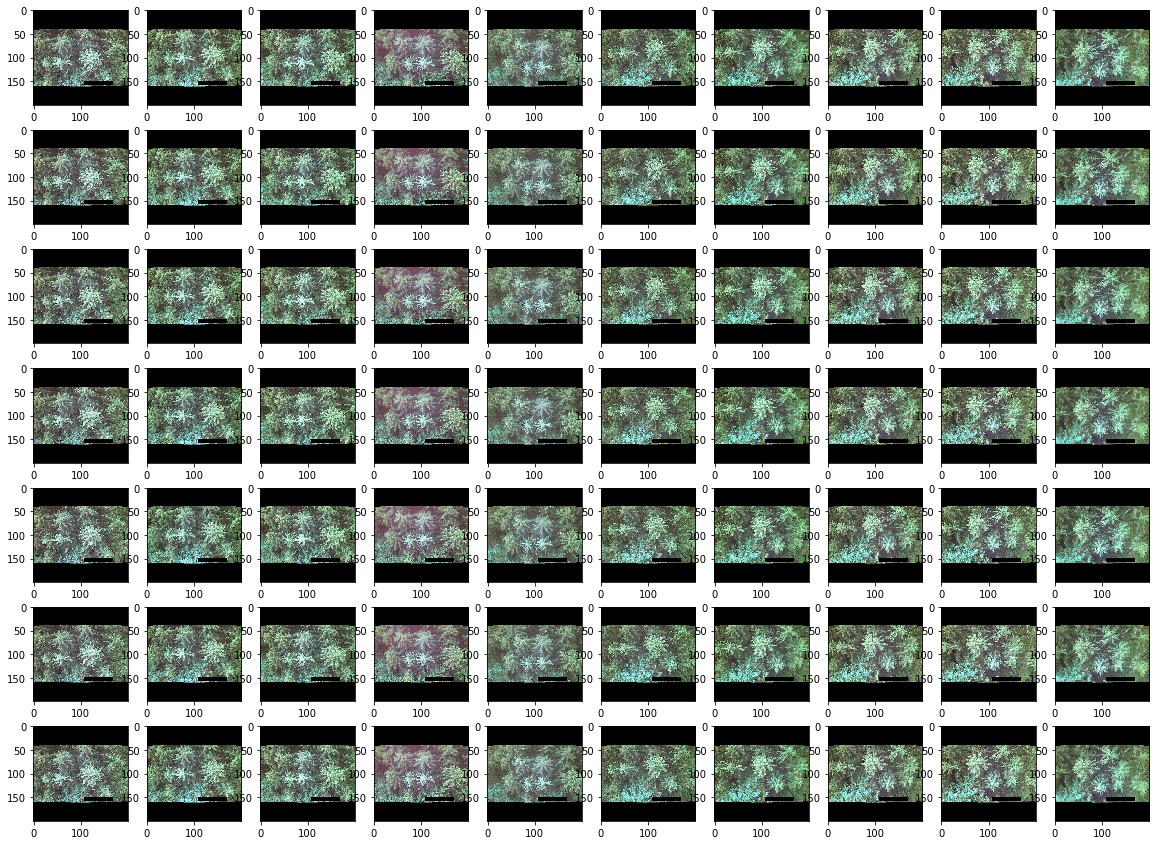

In [104]:
display_images(np.array(orig_images), figsize=(7,10), resize_dim=(200,200))
#display_images(np.array(warped_images), figsize=(7,10), resize_dim=(200,200))

In [177]:
def integrate(images: np.ndarray):

    integrated_images = []
    """
    This is going through all the sets of images,True
    where images[0] represents 10 images in a numpy array
    """
    for i in range(len(images)): 
        integral = np.zeros((images[0].shape[1:]), np.float64)
        #divider = np.zeros((images[0].shape[1:]), np.float64)
        
        for j in range(len(images[i])):
            integral += images[i][j]
            #cc = color_check(images[i][j])
            #integral += (images[i][j]*cc[:,:,np.newaxis])
            #divider += cc[:,:,np.newaxis]

        integral /= len(images[i]) #np.divide(integral, divider, out=np.zeros_like(integral), where=divider!=0)
        integral=cv2.normalize(integral, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        integrated_images.append(integral)

    return integrated_images

In [174]:
def color_check(image: np.ndarray):
    height, width = image.shape[:2]
    cc = np.zeros(image.shape, np.float64)
    for y,x in zip(range(height),range(width)):
        if all(image[x,y] != [0,0,0]):
            cc[x,y]=[0,0,0]
    return np.array(cc)


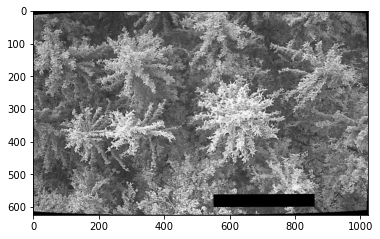

In [110]:
def crop_image(image):

    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _,thresh = cv2.threshold(grayscale,0,255,cv2.THRESH_OTSU)

    bbox = cv2.boundingRect(thresh)
    x,y,w,h = bbox
    
    return x,y,w,h
    #plt.imshow(grayscale[y:y+h,x:x+w], cmap='gray')

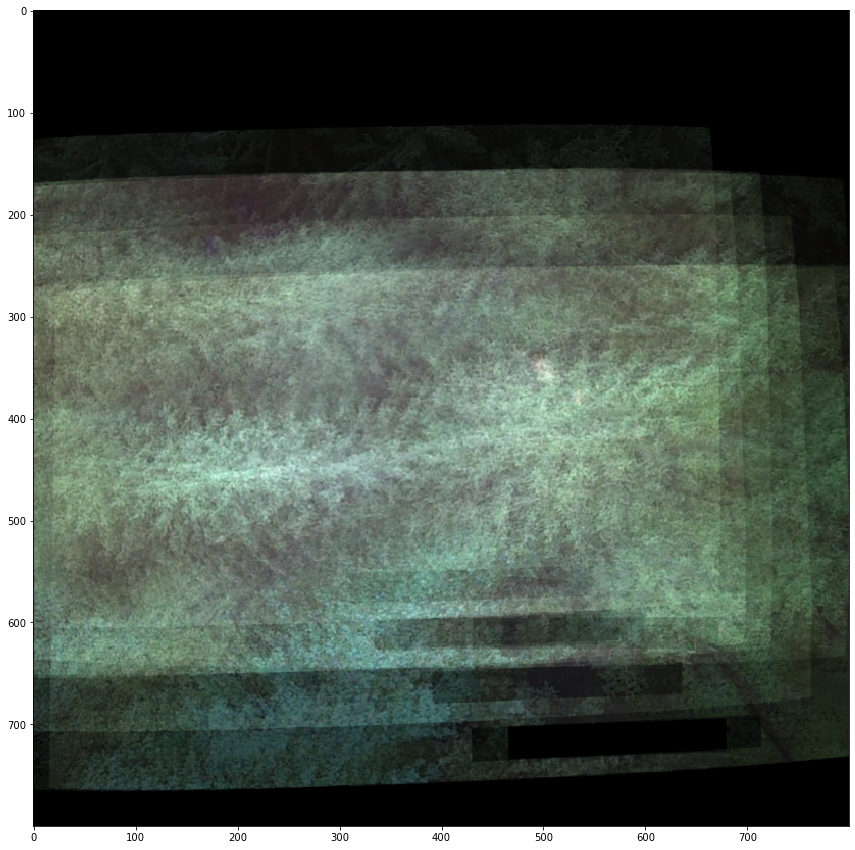

In [178]:
integrated_images = integrate(np.array_split(warped_images,10))

int_img = [integrated_images[0]]

display_images(np.array(int_img), resize_dim=(800,800))

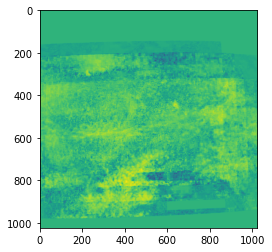

In [179]:
rxvals = []

for img in integrated_images:
    rxvals.append(sp.rx(img))

nbands = integrated_images[0].shape[-1]
P=chi2.ppf(0.99999, nbands)

#v=plt.imshow(1*(rxvals[0]>P))
v = plt.imshow(np.log(rxvals[0]))
#print(rxvals[0])